In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import sweetviz as sv
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('Global.csv')
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239177 entries, 0 to 239176
Data columns (total 7 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             239177 non-null  object 
 1   AverageTemperature             228175 non-null  float64
 2   AverageTemperatureUncertainty  228175 non-null  float64
 3   City                           239177 non-null  object 
 4   Country                        239177 non-null  object 
 5   Latitude                       239177 non-null  object 
 6   Longitude                      239177 non-null  object 
dtypes: float64(2), object(5)
memory usage: 12.8+ MB


In [4]:
df.dt = pd.to_datetime(df.dt)

In [5]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [6]:
df = df.rename(columns={'dt': 'date', 'AverageTemperature': 'temp'})

In [7]:
df = df[df['City'].str.match('Nairobi')]

In [8]:
df.isnull().sum()

date                               0
temp                             287
AverageTemperatureUncertainty    287
City                               0
Country                            0
Latitude                           0
Longitude                          0
dtype: int64

In [9]:
df = df.set_index('date').sort_index()
df.head()

,temp,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
date,,,,,,
1850-01-01,15.759,1.496,Nairobi,Kenya,0.80S,36.16E
1850-02-01,17.145,1.496,Nairobi,Kenya,0.80S,36.16E
1850-03-01,16.988,2.248,Nairobi,Kenya,0.80S,36.16E
1850-04-01,15.844,1.597,Nairobi,Kenya,0.80S,36.16E
1850-05-01,14.686,0.998,Nairobi,Kenya,0.80S,36.16E


In [10]:
df.index.min(), df.index.max()

(Timestamp('1850-01-01 00:00:00'), Timestamp('2013-09-01 00:00:00'))

In [11]:
df.shape[0], df.index.nunique()


(1965, 1965)

[Text(0.5, 1.0, 'Average Temperature by Month'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Temp (F)')]

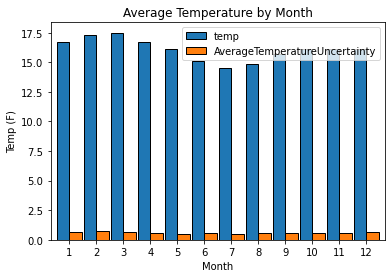

In [12]:
ax = df.groupby(df.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature by Month', xlabel='Month', ylabel='Temp (F)')


[Text(0.5, 1.0, 'Average Temperature by Month'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Temp (F)')]

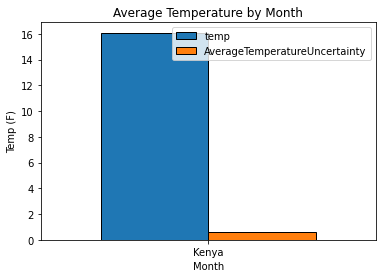

In [13]:
ax = df.groupby(df.Country).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature by Month', xlabel='Month', ylabel='Temp (F)')


<AxesSubplot:xlabel='date'>

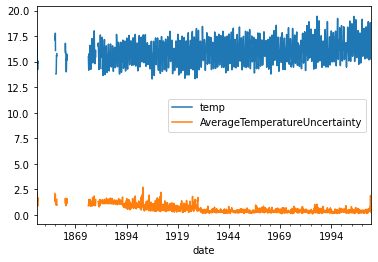

In [14]:
df.plot()

In [15]:
df['City'].value_counts()

Nairobi    1965
Name: City, dtype: int64

In [16]:
df = df[df['City'].str.match('Nairobi')]

In [17]:
df.City.value_counts()

Nairobi    1965
Name: City, dtype: int64

In [18]:
df.head()

,temp,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
date,,,,,,
1850-01-01,15.759,1.496,Nairobi,Kenya,0.80S,36.16E
1850-02-01,17.145,1.496,Nairobi,Kenya,0.80S,36.16E
1850-03-01,16.988,2.248,Nairobi,Kenya,0.80S,36.16E
1850-04-01,15.844,1.597,Nairobi,Kenya,0.80S,36.16E
1850-05-01,14.686,0.998,Nairobi,Kenya,0.80S,36.16E


In [19]:
df = df.drop(columns = ['Country', 'City', 'Latitude', 'Longitude', 'AverageTemperatureUncertainty'])

In [20]:
df.tail(5)

,temp
date,
2013-05-01,16.967
2013-06-01,15.476
2013-07-01,15.240
2013-08-01,15.985
2013-09-01,NaN


In [21]:
df['temp'].isnull().value_counts()

False    1678
True      287
Name: temp, dtype: int64

<AxesSubplot:xlabel='date'>

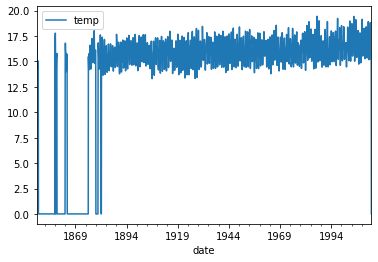

In [22]:
by_date = df.groupby(['date']).temp.sum().reset_index()
by_date.plot(x='date', y='temp')


In [23]:
print('Number of rows:', df.index.nunique())
n_days = df.index.max() - df.index.min() + pd.Timedelta('1M')
print(f"Number of days between first and last day:", n_days)


Number of rows: 1965
Number of days between first and last day: 59778 days 00:01:00


In [24]:
df = df[~(df.index < '1884-01-01') & (df.index != '2013-09-01')]

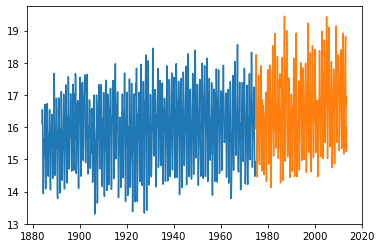

In [25]:
train_size = .70
n = df.shape[0]
test_start_index = round(train_size * n)

train = df[:test_start_index] # everything up (not including) to the test_start_index
test = df[test_start_index:] # everything from the test_start_index to the end

plt.plot(train.index, train.temp)
plt.plot(test.index, test.temp)


In [26]:
y = train.temp
y.head(20)

date
1884-01-01    16.111
1884-02-01    16.545
1884-03-01    16.299
1884-04-01    15.827
1884-05-01    14.855
1884-06-01    14.082
1884-07-01    13.932
1884-08-01    14.294
1884-09-01    15.347
1884-10-01    15.246
1884-11-01    15.124
1884-12-01    15.643
1885-01-01    15.438
1885-02-01    16.641
1885-03-01    16.709
1885-04-01    16.285
1885-05-01    15.532
1885-06-01    14.429
1885-07-01    14.087
1885-08-01    14.617
Name: temp, dtype: float64

<AxesSubplot:ylabel='Frequency'>

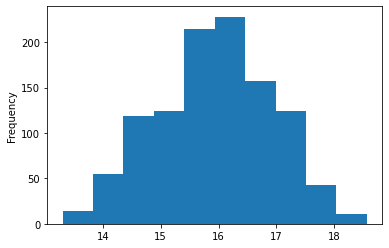

In [27]:
y.plot.hist()

[Text(0.5, 1.0, 'Average Temperature by Month'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Temp (C)')]

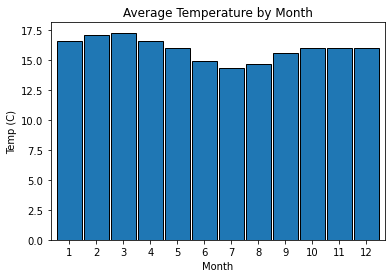

In [28]:
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature by Month', xlabel='Month', ylabel='Temp (C)')


[Text(0.5, 1.0, 'Average Temperature by Weekday'),
 Text(0.5, 17.200000000000003, 'Weekday'),
 Text(17.200000000000003, 0.5, 'Temp (C)')]

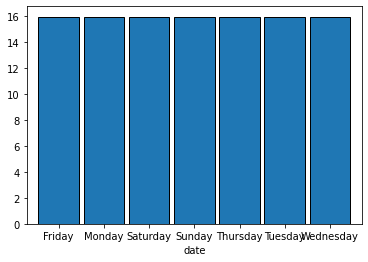

In [29]:
y.groupby(y.index.day_name()).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature by Weekday', xlabel='Weekday', ylabel='Temp (C)')


<AxesSubplot:xlabel='date'>

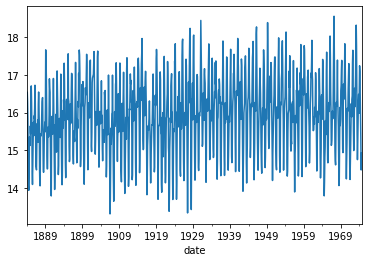

In [30]:
y.plot()

<AxesSubplot:title={'center':'Monthly average'}, xlabel='date'>

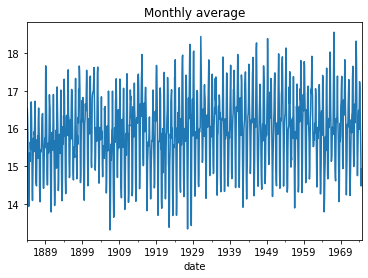

In [31]:
y.resample('M').mean().plot(title='Monthly average')


<AxesSubplot:title={'center':'Yearly average'}, xlabel='date'>

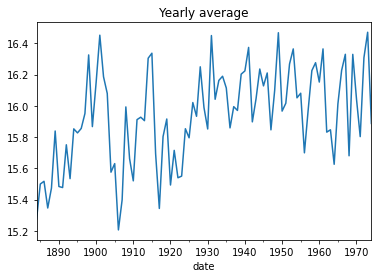

In [32]:
y.resample('Y').mean().plot(title='Yearly average')


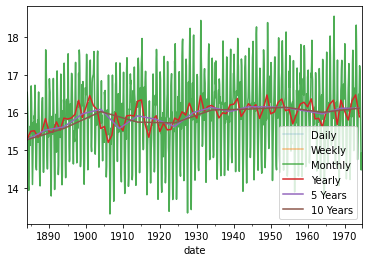

In [33]:
y.plot(alpha=.2, label='Daily')
y.resample('W').mean().plot(alpha=.5, label='Weekly')
y.resample('M').mean().plot(alpha=.8, label='Monthly')
y.resample('Y').mean().plot(label='Yearly')
y.resample('5Y').mean().plot(label='5 Years')
y.resample('10Y').mean().plot(label='10 Years')
plt.legend()


<AxesSubplot:title={'center':'Average year-to-year change in temperature'}, xlabel='date'>

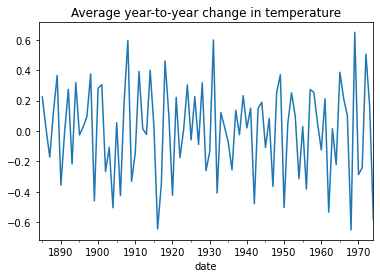

In [34]:
y.resample('Y').mean().diff().plot(title='Average year-to-year change in temperature')


<AxesSubplot:title={'center':'Average 5 Years change in temperature'}, xlabel='date'>

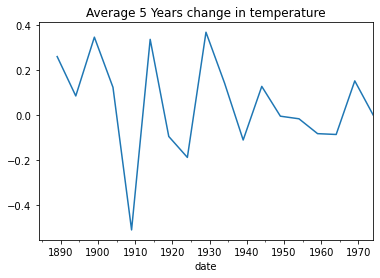

In [35]:
y.resample('5Y').mean().diff().plot(title='Average 5 Years change in temperature')

<AxesSubplot:title={'center':'Average Ten Years change in temperature'}, xlabel='date'>

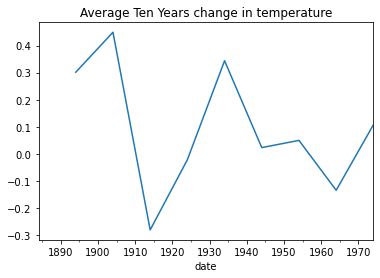

In [36]:
y.resample('10Y').mean().diff().plot(title='Average Ten Years change in temperature')

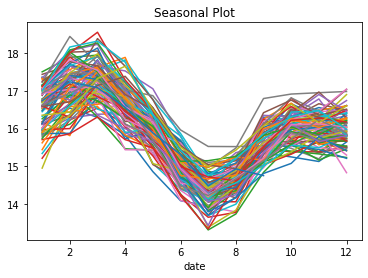

In [37]:
# .unstack turns an index level into columns
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot').get_legend().remove()

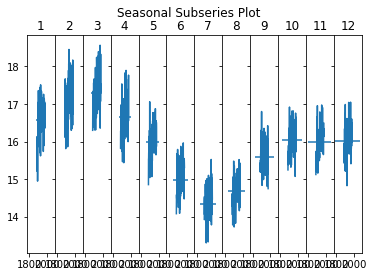

In [38]:
table = y.groupby([y.index.year, y.index.month]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim())
    ax.set(xlabel='')

fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

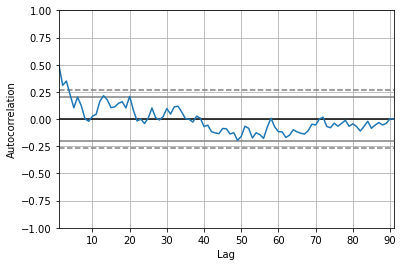

In [39]:
pd.plotting.autocorrelation_plot(train.temp.resample('Y').mean())


In [40]:
y = train.temp.resample('Y').mean()

result = sm.tsa.seasonal_decompose(y, model='additive')
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()


,y,trend,seasonal,resid
date,,,,
1884-12-31,15.275417,15.275417,0.0,0.0
1885-12-31,15.499167,15.499167,0.0,0.0
1886-12-31,15.516833,15.516833,0.0,0.0
1887-12-31,15.345917,15.345917,0.0,0.0
1888-12-31,15.473167,15.473167,0.0,0.0


<AxesSubplot:xlabel='date'>

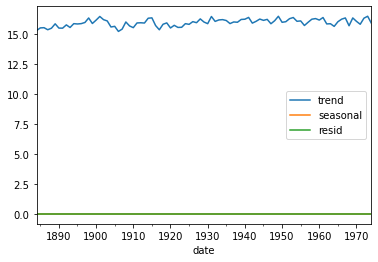

In [41]:
decomposition.iloc[:, 1:].plot()


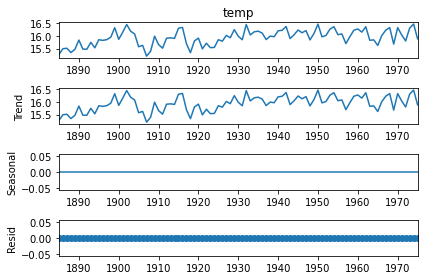

In [42]:
# the value returned from seasonal_decompose can itself be plotted:
result.plot()
None


In [43]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]


In [44]:
train, validate, test

(              temp
 date              
 1884-01-01  16.111
 1884-02-01  16.545
 1884-03-01  16.299
 1884-04-01  15.827
 1884-05-01  14.855
 ...            ...
 1948-06-01  14.853
 1948-07-01  14.536
 1948-08-01  14.815
 1948-09-01  15.609
 1948-10-01  16.095
 
 [778 rows x 1 columns],
               temp
 date              
 1948-11-01  15.810
 1948-12-01  15.848
 1949-01-01  16.600
 1949-02-01  17.074
 1949-03-01  18.393
 ...            ...
 1987-04-01  18.087
 1987-05-01  16.820
 1987-06-01  15.360
 1987-07-01  14.944
 1987-08-01  15.469
 
 [466 rows x 1 columns],
               temp
 date              
 1987-09-01  17.135
 1987-10-01  17.809
 1987-11-01  16.997
 1987-12-01  17.629
 1988-01-01  17.454
 ...            ...
 2013-04-01  16.674
 2013-05-01  16.967
 2013-06-01  15.476
 2013-07-01  15.240
 2013-08-01  15.985
 
 [312 rows x 1 columns])

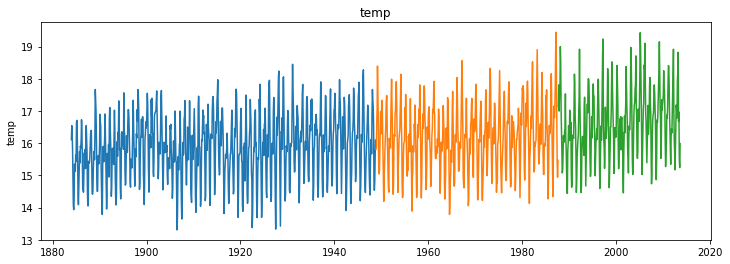

In [45]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()


In [46]:
train.head()

,temp
date,
1884-01-01,16.111
1884-02-01,16.545
1884-03-01,16.299
1884-04-01,15.827
1884-05-01,14.855


In [47]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse


In [48]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()


In [49]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)


In [50]:
temp = round(train['temp'][-1:][0], 2)


yhat_df = pd.DataFrame({'temp': [temp]}, 
                       index = validate.index)

yhat_df.head(2)


,temp
date,
1948-11-01,16.1
1948-12-01,16.1


temp -- RMSE: 1


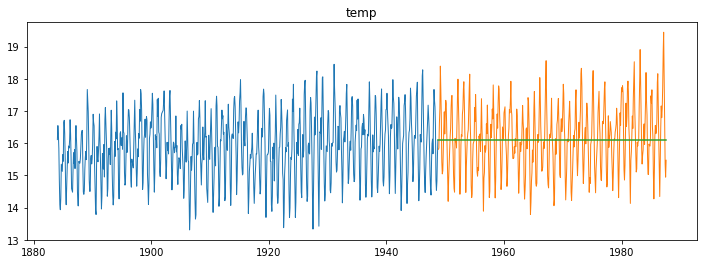

In [51]:
plot_and_eval(col)

In [61]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)
    
eval_df


,model_type,target_var,rmse
0,last_observed_value,temp,1.0
1,12d moving average,temp,1.0
2,24d moving average,temp,1.0
3,60d moving average,temp,1.0
4,120d moving average,temp,1.0
5,last_observed_value,temp,1.0
6,last_observed_value,temp,1.0


In [53]:
temp = round(train['temp'].mean(), 2)

yhat_df = pd.DataFrame({'temp': [temp]
                           }, index = validate.index)
yhat_df.head(3)

,temp
date,
1948-11-01,15.88
1948-12-01,15.88
1949-01-01,15.88


temp -- RMSE: 1


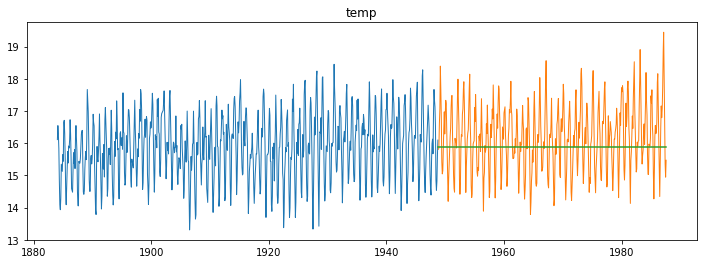

In [54]:
plot_and_eval(col)

temp -- RMSE: 1


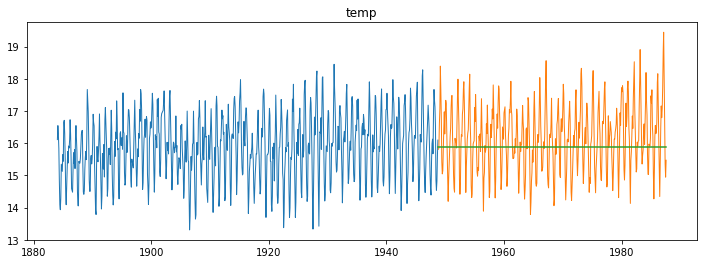

In [55]:
for col in train.columns:
    plot_and_eval(col)


In [56]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 30

items = round(train['temp'].rolling(period).mean().iloc[-1], 2)


# yhat_df = make_predictions()

yhat_df = pd.DataFrame({'temp': [items]
                           }, index = validate.index)
yhat_df.head(2)


,temp
date,
1948-11-01,15.85
1948-12-01,15.85


temp -- RMSE: 1


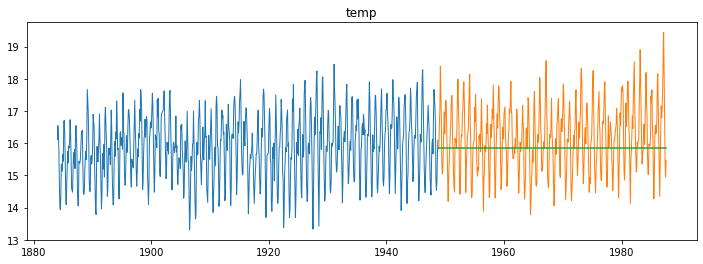

In [57]:
for col in train.columns:
    plot_and_eval(col)

In [58]:
evaluate(col)

1.0

In [63]:
periods = [12, 24, 60, 120]

for p in periods:
    temp = round(train['temp'].rolling(p).mean().iloc[-1], 2)
    
    yhat_df = pd.DataFrame({'temp': [temp]}, index = validate.index)

    model_type = str(p) + 'm moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'temp')
eval_df

,model_type,target_var,rmse
0,last_observed_value,temp,1.0
1,12d moving average,temp,1.0
2,24d moving average,temp,1.0
3,60d moving average,temp,1.0
4,120d moving average,temp,1.0
5,last_observed_value,temp,1.0
6,last_observed_value,temp,1.0
7,12m moving average,temp,1.0
8,24m moving average,temp,1.0
9,60m moving average,temp,1.0


In [67]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)
    
yhat_df


,temp
date,
1948-11-01,15.81
1948-12-01,15.79
1949-01-01,15.78
1949-02-01,15.77
1949-03-01,15.75
...,...
1987-04-01,9.27
1987-05-01,9.26
1987-06-01,9.24


temp -- RMSE: 4


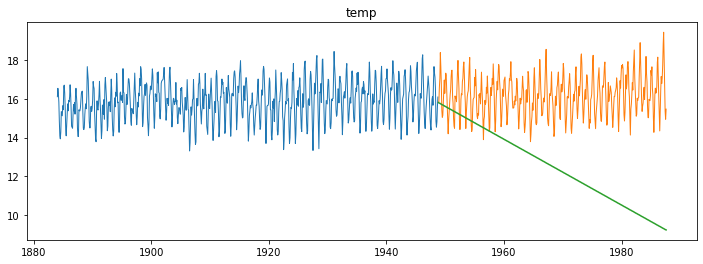

In [68]:
for col in train.columns:
    plot_and_eval(col)

In [79]:
train = df['2005':'2010']
validate = df['2011']
test = df['2012']


In [80]:
yhat_df = train['2010'] + train.diff(365).mean()
yhat_df

,temp
date,
2010-01-01,NaN
2010-02-01,NaN
2010-03-01,NaN
2010-04-01,NaN
2010-05-01,NaN
2010-06-01,NaN
2010-07-01,NaN
2010-08-01,NaN
2010-09-01,NaN


In [74]:
pd.concat([yhat_df.head(1), validate.head(1)])


,temp
date,
2010-01-01,17.732235
2011-01-01,17.768000


In [78]:
for col in train.columns:
    plot_and_eval(target_var = col(['2005'], ['2014'])
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)


SyntaxError: invalid syntax (395654136.py, line 3)